# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Load the Data/Filtering for Chosen Zipcodes

In [210]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [814]:
df = pd.read_csv('data/zillow_data.csv')

In [783]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Filter data for all zipcodes within the city of Fort Lauderdale

In [784]:
df = df[df['City'] == 'Fort Lauderdale']

In [785]:
df = df.drop(columns=['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
df = df.reset_index(drop=True)

In [786]:
df.head(8)

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,33308,206000.0,205900.0,205700.0,205500.0,205300.0,205300.0,205300.0,205500.0,206100.0,...,587200,589600,589300,589900,590700,594500,603200,613300,622700,630200
1,33312,81100.0,81000.0,81000.0,81000.0,81100.0,81300.0,81500.0,81800.0,82300.0,...,240400,243600,246400,249200,251900,254000,255600,257000,258700,260300
2,33304,149400.0,149700.0,149900.0,150100.0,150300.0,150500.0,150700.0,151300.0,152200.0,...,475400,474400,474200,476200,478500,479300,480700,485000,490100,492200
3,33301,320500.0,321300.0,322200.0,323200.0,324200.0,325300.0,326400.0,328000.0,330200.0,...,1100700,1103500,1103600,1101400,1102200,1108500,1110300,1114100,1130800,1145800
4,33316,291700.0,292300.0,292900.0,293500.0,294100.0,294800.0,295700.0,296700.0,298300.0,...,982600,987100,995000,1005600,1011300,1012200,1009900,1023000,1054400,1079800
5,33305,144600.0,144900.0,145200.0,145500.0,145700.0,146000.0,146400.0,146800.0,147500.0,...,508000,511100,515800,520300,522100,522800,524700,526600,527200,526500
6,33315,92800.0,92900.0,93100.0,93200.0,93400.0,93600.0,93900.0,94300.0,95000.0,...,309000,311300,313100,314400,314300,313300,312700,313700,317700,322000
7,33306,206200.0,206600.0,207000.0,207400.0,207800.0,208100.0,208500.0,209100.0,209900.0,...,635700,629700,625000,624600,624300,624800,626900,630900,636800,642300


In [787]:
zipcodes = list(df['RegionName'])
zipcodes

[33308, 33312, 33304, 33301, 33316, 33305, 33315, 33306]

# Data Preprocessing

## Transpose data; Ensure clean data and no missing values

In [788]:
dft = df.T
dft = dft.drop('RegionName', axis=0)

In [789]:
dft.head()

,0,1,2,3,4,5,6,7
1996-04,206000.0,81100.0,149400.0,320500.0,291700.0,144600.0,92800.0,206200.0
1996-05,205900.0,81000.0,149700.0,321300.0,292300.0,144900.0,92900.0,206600.0
1996-06,205700.0,81000.0,149900.0,322200.0,292900.0,145200.0,93100.0,207000.0
1996-07,205500.0,81000.0,150100.0,323200.0,293500.0,145500.0,93200.0,207400.0
1996-08,205300.0,81100.0,150300.0,324200.0,294100.0,145700.0,93400.0,207800.0


In [790]:
dft = dft.reset_index()
dft['index'] = pd.to_datetime(dft['index'], format="%Y-%m")
dft = dft.set_index('index')

In [791]:
dft = dft['2012':]

In [792]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 76 entries, 2012-01-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       76 non-null     float64
 1   1       76 non-null     float64
 2   2       76 non-null     float64
 3   3       76 non-null     float64
 4   4       76 non-null     float64
 5   5       76 non-null     float64
 6   6       76 non-null     float64
 7   7       76 non-null     float64
dtypes: float64(8)
memory usage: 5.3 KB


In [793]:
dft.describe()

,0,1,2,3,4,5,6,7
count,76.000000,76.000000,76.000000,7.600000e+01,7.600000e+01,76.000000,76.000000,76.000000
mean,519282.894737,174135.526316,402253.947368,9.429355e+05,8.527566e+05,425805.263158,237726.315789,527461.842105
std,71008.811450,45957.626002,65612.869552,1.401150e+05,1.347572e+05,68227.054057,52328.978252,84974.394523
min,389300.000000,110700.000000,288000.000000,7.037000e+05,6.280000e+05,302000.000000,160600.000000,387800.000000
25%,464650.000000,137050.000000,351025.000000,8.441750e+05,7.528750e+05,371625.000000,190725.000000,463250.000000
50%,533000.000000,170500.000000,415250.000000,9.329500e+05,8.557000e+05,424900.000000,236700.000000,525700.000000
75%,587600.000000,206550.000000,470000.000000,1.100875e+06,9.797000e+05,494100.000000,282925.000000,618900.000000
max,630200.000000,260300.000000,492200.000000,1.145800e+06,1.079800e+06,527200.000000,322000.000000,660400.000000


## Train-Test-Split

In [794]:
train, test = dft.iloc[:60], dft.iloc[60:]

## Create individual series for each zipcode

In [795]:
trdf1 = pd.DataFrame(train[0]).rename(columns={0:'Actual'})
trdf2 = pd.DataFrame(train[1]).rename(columns={1:'Actual'})
trdf3 = pd.DataFrame(train[2]).rename(columns={2:'Actual'})
trdf4 = pd.DataFrame(train[3]).rename(columns={3:'Actual'})
trdf5 = pd.DataFrame(train[4]).rename(columns={4:'Actual'})
trdf6 = pd.DataFrame(train[5]).rename(columns={5:'Actual'})
trdf7 = pd.DataFrame(train[6]).rename(columns={6:'Actual'})
trdf8 = pd.DataFrame(train[7]).rename(columns={7:'Actual'})

tedf1 = pd.DataFrame(test[0]).rename(columns={0:'Actual'})
tedf2 = pd.DataFrame(test[1]).rename(columns={1:'Actual'})
tedf3 = pd.DataFrame(test[2]).rename(columns={2:'Actual'})
tedf4 = pd.DataFrame(test[3]).rename(columns={3:'Actual'})
tedf5 = pd.DataFrame(test[4]).rename(columns={4:'Actual'})
tedf6 = pd.DataFrame(test[5]).rename(columns={5:'Actual'})
tedf7 = pd.DataFrame(test[6]).rename(columns={6:'Actual'})
tedf8 = pd.DataFrame(test[7]).rename(columns={7:'Actual'})

df1 = pd.DataFrame(dft[0])
df2 = pd.DataFrame(dft[1])
df3 = pd.DataFrame(dft[2])
df4 = pd.DataFrame(dft[3])
df5 = pd.DataFrame(dft[4])
df6 = pd.DataFrame(dft[5])
df7 = pd.DataFrame(dft[6])
df8 = pd.DataFrame(dft[7])

In [796]:
dfs = [df1, df2, df3, df4, df5, df6, df7, df8]
trdfs = [trdf1, trdf2, trdf3, trdf4, trdf5, trdf6, trdf7, trdf8]
tedfs = [tedf1, tedf2, tedf3, tedf4, tedf5, tedf6, tedf7, tedf8]

## Visual stationarity check

In [17]:
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 12}

#matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

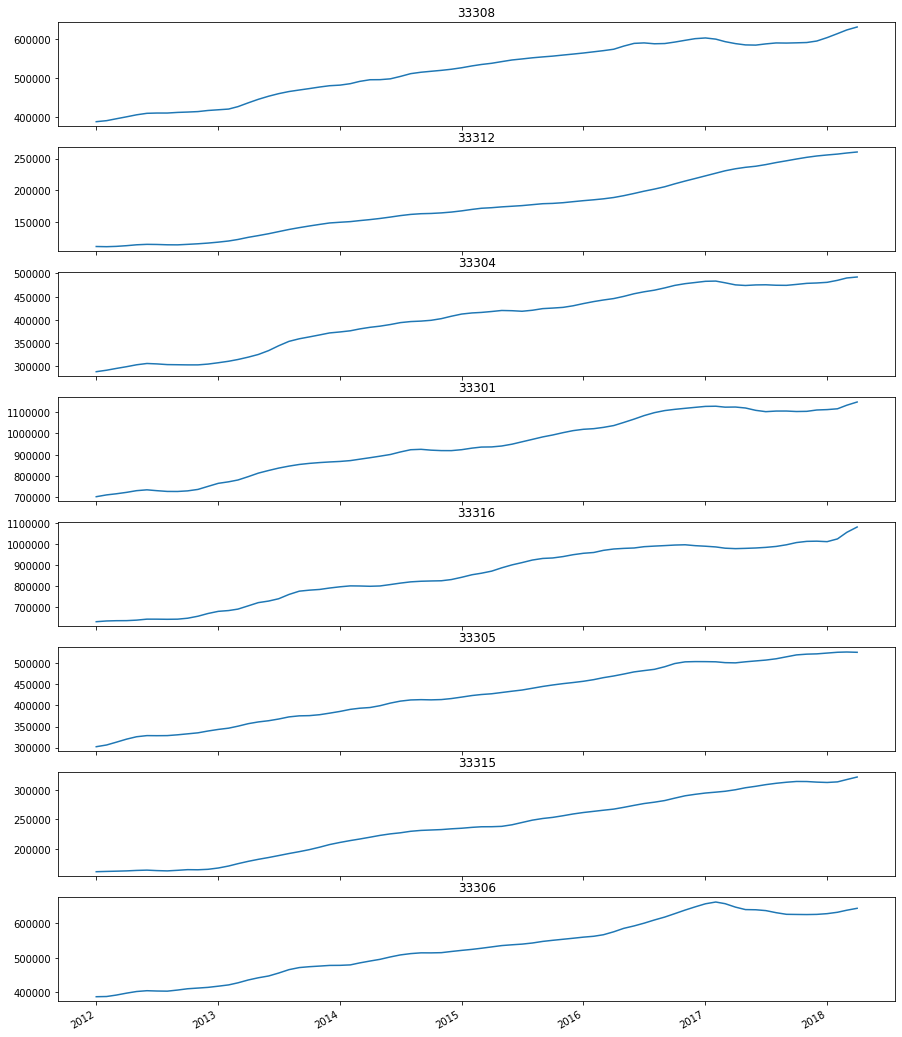

In [18]:
plt.figure(figsize=(15,20))

for n, c in enumerate(dft):
    newn = str(n+1)
    base = '81'
    subnum = base+newn
    plt.subplot(subnum)
    plt.plot(dft[c])
    titl = zipcodes[n]
    plt.title(titl)

plt.gcf().autofmt_xdate()

### Observations
- None of these series appear stationary
- No apparent seasonality, except for maybe at the decade level
- All the curves are fairly similar in shape, which makes sense given the physical proximity of the zipcodes

# EDA

## Seasonality Decomposition

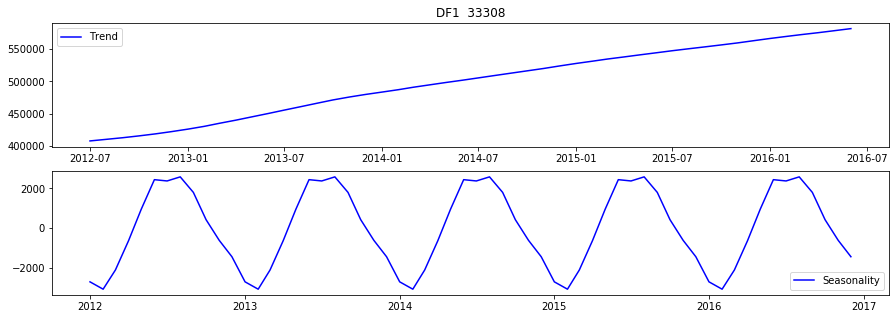

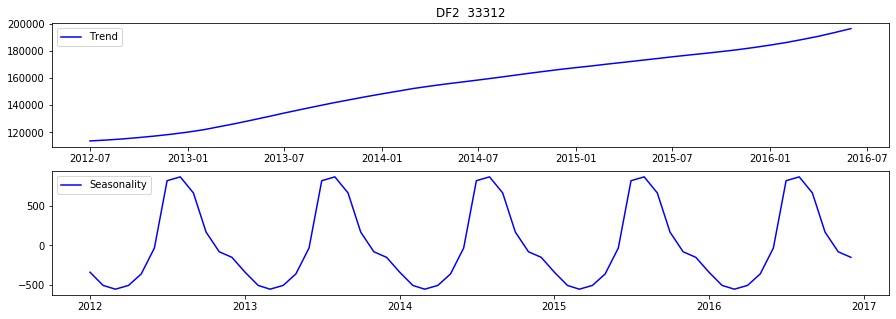

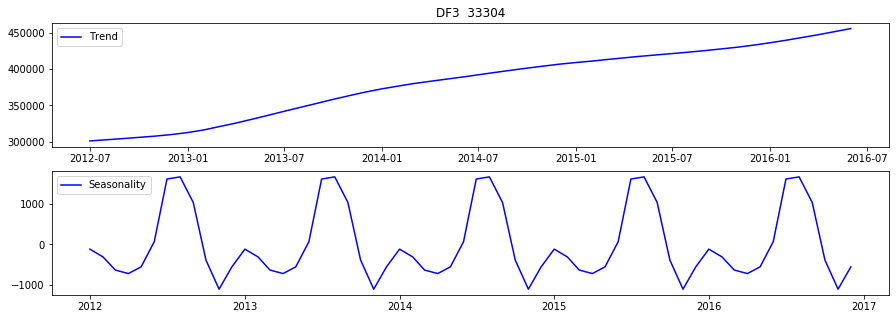

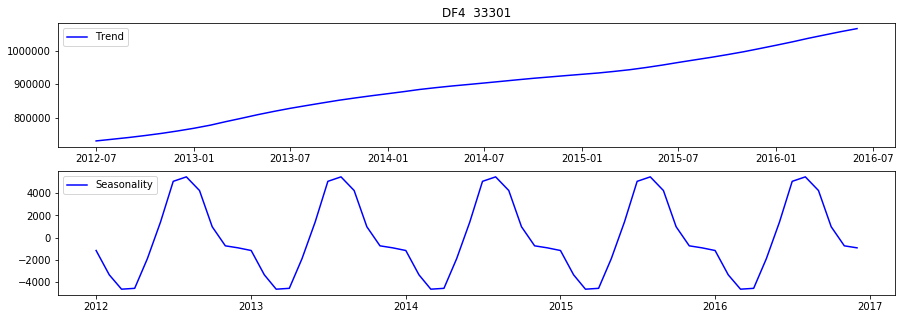

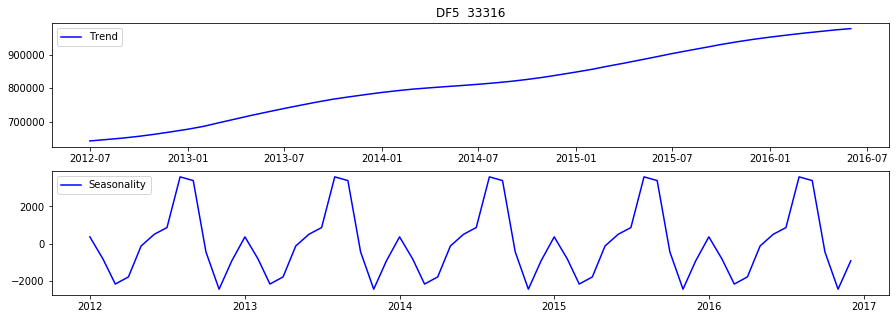

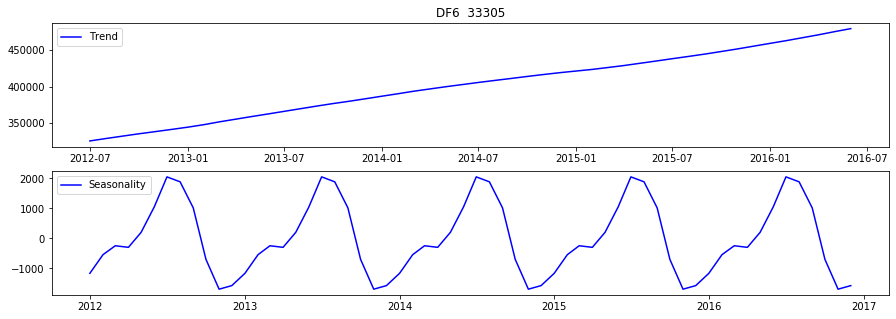

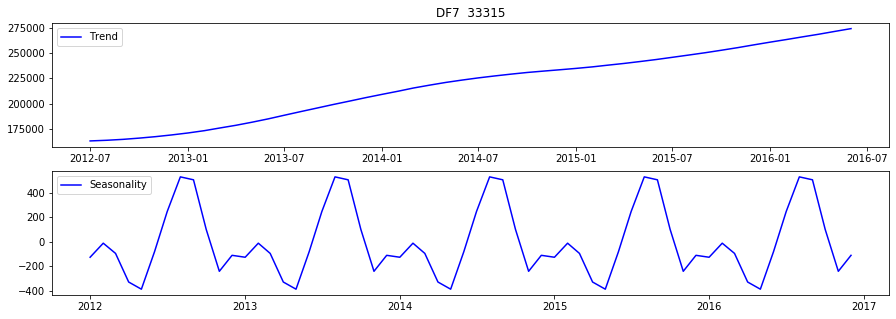

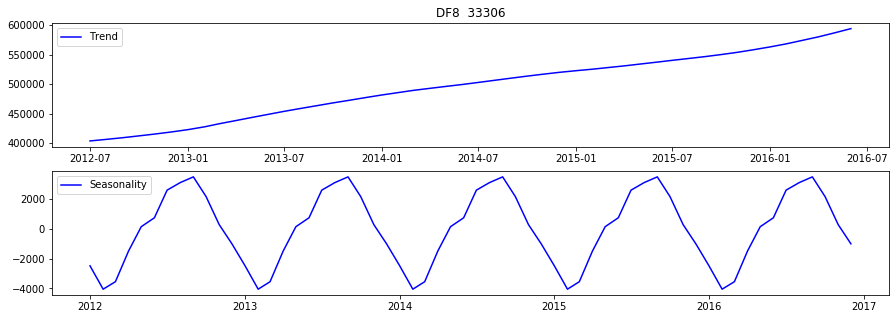

In [404]:
for n, df in enumerate(trdfs):
    decomposition = seasonal_decompose(df, model='additive')
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    
    plt.figure(figsize=(15,5))
    plt.subplot(211)
    plt.plot(trend, label='Trend', color='blue')
    num = str(n+1)
    zips = str(zipcodes[n])
    name = 'DF'+num+'  '+zips
    plt.title(name)
    
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')

In [409]:
residuals = []

for n, df in enumerate(trdfs):
    decomp = seasonal_decompose(df, model='additive')
    resid = decomp.resid.dropna()
    residuals.append(resid)

### Conclusion
- All time series' have annual seasonality, though it is not nominally large (a few thousand dollars at most)

## Dickey-Fuller Test

### Original

In [162]:
def fullertest(df):
    dftest = adfuller(df)
    
    # Extract and display test results in a user friendly manner (code taken from Section 37)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print('P-value of Dickey-Fuller test: ', dfoutput[1], ' \n\n')

In [163]:
for n, d in enumerate(trdfs):
    num = n+1
    print('Zipcode No. ', num)
    fullertest(d['Actual'])

Zipcode No.  1
P-value of Dickey-Fuller test:  0.753611221999089  


Zipcode No.  2
P-value of Dickey-Fuller test:  0.9950803886464  


Zipcode No.  3
P-value of Dickey-Fuller test:  0.6509179000928571  


Zipcode No.  4
P-value of Dickey-Fuller test:  0.958532843992522  


Zipcode No.  5
P-value of Dickey-Fuller test:  0.6014676661153996  


Zipcode No.  6
P-value of Dickey-Fuller test:  0.9941144587101117  


Zipcode No.  7
P-value of Dickey-Fuller test:  0.9089925676730407  


Zipcode No.  8
P-value of Dickey-Fuller test:  0.99811406603404  




#### Conclusions

All the Dickey-Fuller tests came back with statistically insignifcant results, indicating that none of the 8 time series' are stationary (though some are closer to stationarity than others).

### Residuals

In [410]:
for n, r in enumerate(residuals):
    num = n+1
    print('DF', num)
    fullertest(r)

DF 1
P-value of Dickey-Fuller test:  0.0005141575512987538  


DF 2
P-value of Dickey-Fuller test:  0.03971678991419471  


DF 3
P-value of Dickey-Fuller test:  0.0055008324758825805  


DF 4
P-value of Dickey-Fuller test:  0.050435198477251246  


DF 5
P-value of Dickey-Fuller test:  0.0012616972431257313  


DF 6
P-value of Dickey-Fuller test:  0.03844216472412113  


DF 7
P-value of Dickey-Fuller test:  0.2616024349893218  


DF 8
P-value of Dickey-Fuller test:  0.0013440771307117977  




#### Conclusions
- Only df4 and df7 need to be differenced for stationarity

## Optimize differencing

### Original

In [164]:
def difffuller(df):
    p = 1
    d = 0
    while p>.05:
        d += 1
        diff = df['Actual'].diff(d)
        dftest = adfuller(diff.dropna())
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 
                                             'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        p = dfoutput[1]
    return((d, p))

In [165]:
for n, df in enumerate(trdfs):
    rez = difffuller(df)
    print('DF',n+1,'  ', zipcodes[n], '   Periods differenced: ', rez[0], '   P-value: ', rez[1])

DF 1    33308    Periods differenced:  1    P-value:  0.0028392568765576065
DF 2    33312    Periods differenced:  19    P-value:  0.014732818075688143
DF 3    33304    Periods differenced:  1    P-value:  0.01661922530968868
DF 4    33301    Periods differenced:  1    P-value:  0.0028700083657375347
DF 5    33316    Periods differenced:  1    P-value:  0.03958423115298573
DF 6    33305    Periods differenced:  1    P-value:  0.03196606490881846
DF 7    33315    Periods differenced:  2    P-value:  0.03236281651092226
DF 8    33306    Periods differenced:  16    P-value:  0.035151951502350405


#### Results

In [23]:
differences = [1, 19, 1, 1, 1, 1, 2, 16]
forced_diffs = [1, 2, 1, 1, 1, 1, 2, 2]

### Residuals

In [265]:
def difffuller_rez(df):
    p = 1
    d = 0
    while p>.05:
        d += 1
        diff = df.diff(d)
        dftest = adfuller(diff.dropna())
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 
                                             'Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        p = dfoutput[1]
    return((d, p))

In [266]:
for n, r in enumerate(residuals):
    rez = difffuller_rez(r)
    print('DF',n+1,'  ', zipcodes[n], '   Periods differenced: ', rez[0], '   P-value: ', rez[1])

DF 1    33308    Periods differenced:  1    P-value:  0.0005609460314868432
DF 2    33312    Periods differenced:  1    P-value:  4.415045188406887e-05
DF 3    33304    Periods differenced:  1    P-value:  0.0037072739554915896
DF 4    33301    Periods differenced:  1    P-value:  1.4391008572320427e-05
DF 5    33316    Periods differenced:  4    P-value:  0.01389819543975473
DF 6    33305    Periods differenced:  1    P-value:  2.84087206069884e-10
DF 7    33315    Periods differenced:  1    P-value:  9.794121899283958e-06
DF 8    33306    Periods differenced:  1    P-value:  1.4282080566732312e-05


But since only DF4 and DF7 have residuals that are non-stationary:

In [259]:
difffuller_rez(trdf4)

(1, 0.0028700083657375347)

In [260]:
difffuller_rez(trdf7)

(2, 0.03236281651092226)

#### Results

In [267]:
rezdiffs = [0,0,0,1,0,0,2,0]

### Plot of differenced-to-stationarity time series

#### Original

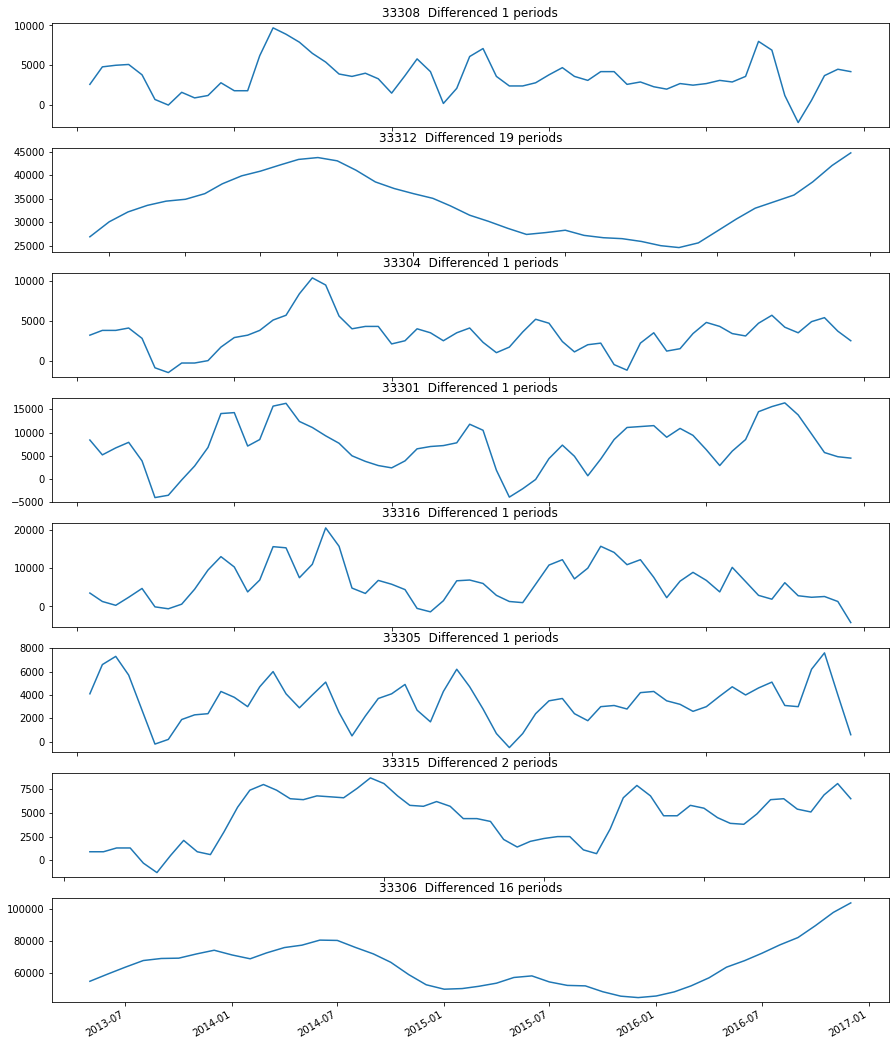

In [24]:
plt.figure(figsize=(15,20))

for n, c in enumerate(trdfs):
    newn = str(n+1)
    base = '81'
    subnum = base+newn
    plt.subplot(subnum)
    plt.plot(c.diff(differences[n]).dropna())
    titl = str(zipcodes[n]) + '  Differenced ' + str(differences[n]) + ' periods'
    plt.title(titl)

plt.gcf().autofmt_xdate()

#### Residuals

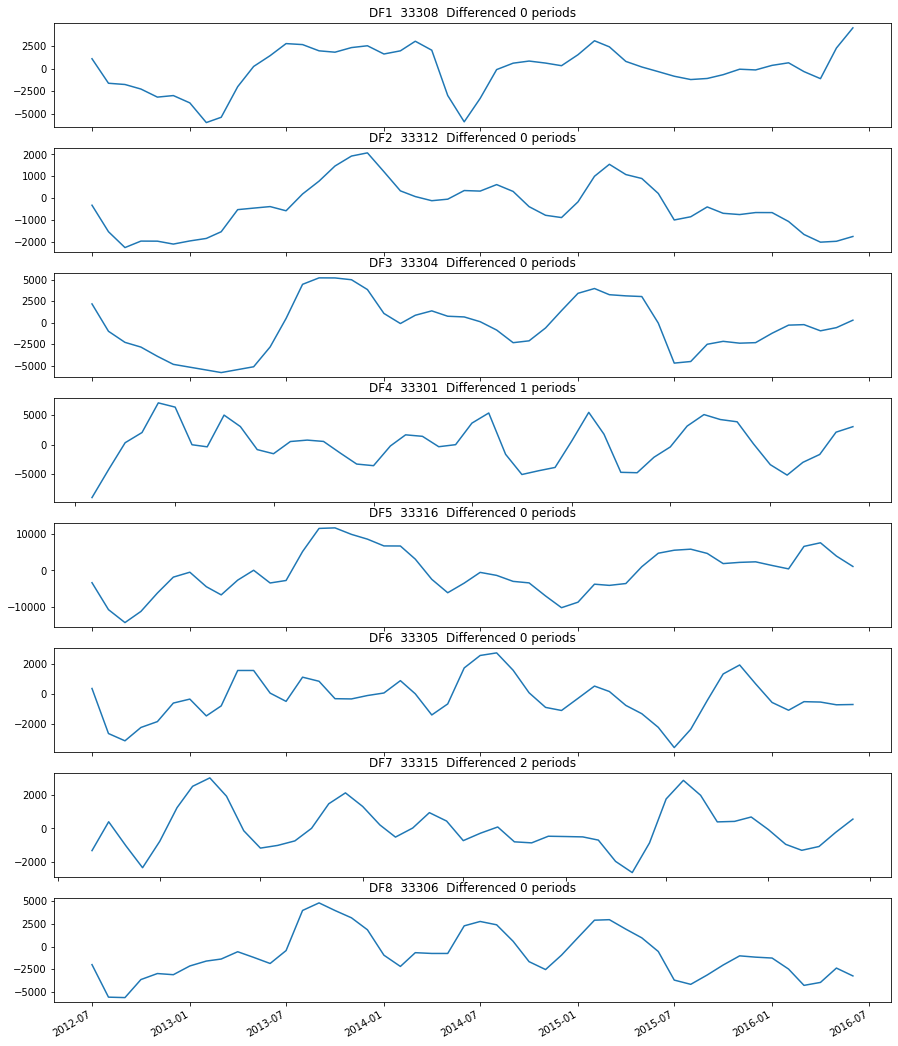

In [289]:
plt.figure(figsize=(15,20))

for n, c in enumerate(residuals):
    if rezdiffs[n] == 0:
        newn = str(n+1)
        base = '81'
        subnum = base+newn
        plt.subplot(subnum)
        plt.plot(c)
        titl = 'DF' + str(n+1) + '  ' + str(zipcodes[n]) + '  Differenced ' + str(rezdiffs[n]) + ' periods'
        plt.title(titl)
        
    else:
        newn = str(n+1)
        base = '81'
        subnum = base+newn
        plt.subplot(subnum)
        plt.plot(c.diff(rezdiffs[n]).dropna())
        titl = 'DF' + str(n+1) + '  ' + str(zipcodes[n]) + '  Differenced ' + str(rezdiffs[n]) + ' periods'
        plt.title(titl)

plt.gcf().autofmt_xdate()

## Auto-correlation plots

### Original

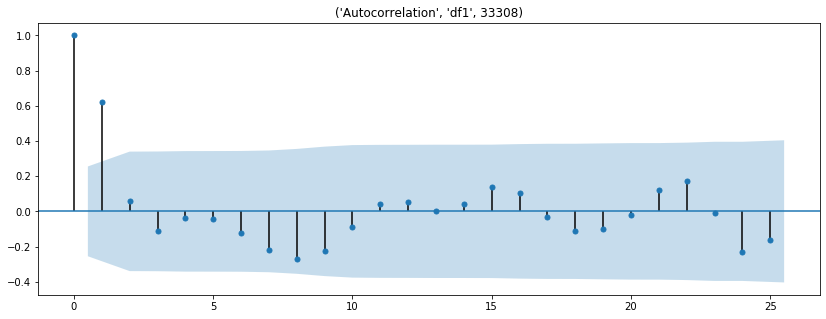

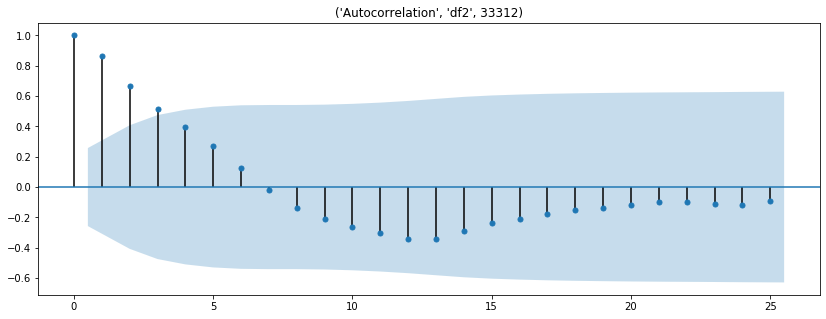

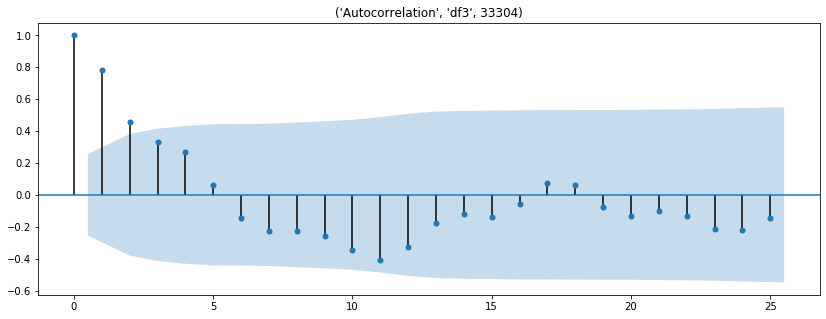

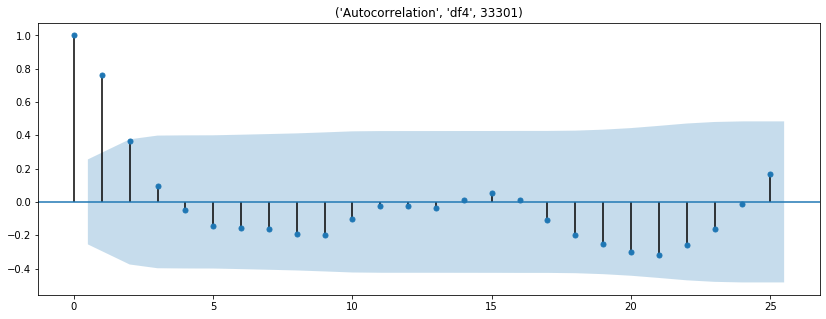

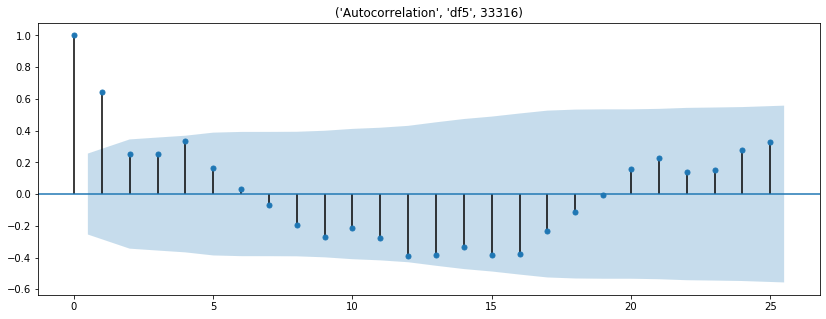

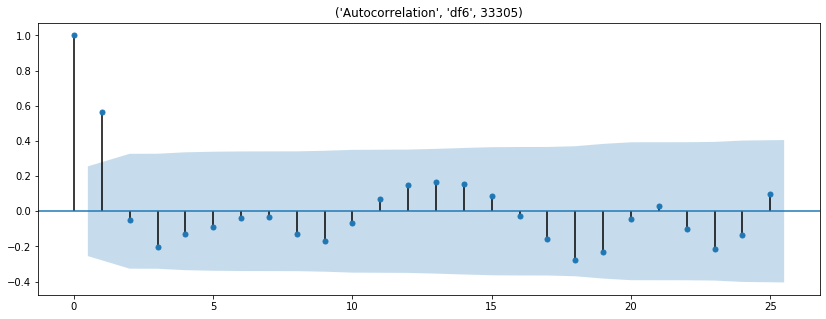

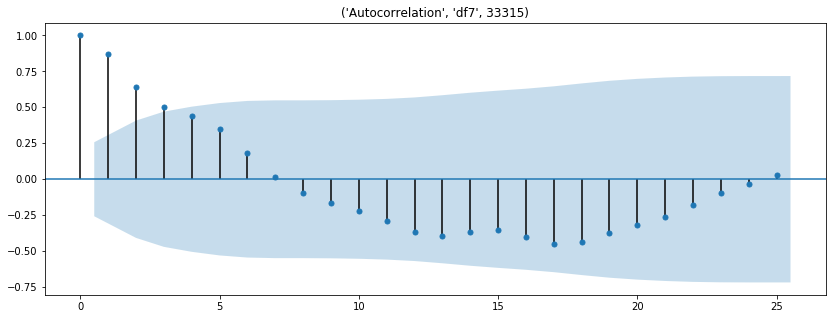

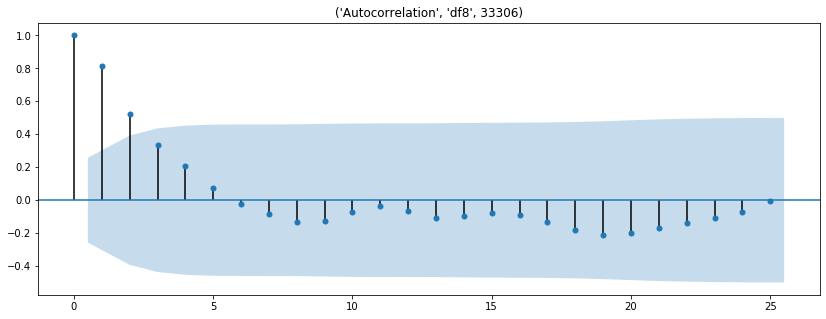

In [25]:
for n, d in enumerate(trdfs):
    rcParams['figure.figsize'] = 14, 5
    titlezip = zipcodes[n]
    dfn = 'df' + str(n+1)
    plot_acf(d.diff(forced_diffs[n]).dropna(), lags=25, title=('Autocorrelation', dfn, titlezip))

#### Original MA Conclusions
- Based on the auto-correlation plots above, the first lag is statistically significant predictors of home value across all 8 zipcodes.
- The 2nd, 3rd, 7th, and 8th zipcodes may have statistically significant lags up to 2 and 3


- 1
- 3 (or maybe 2)
- 2 (or maybe 1)
- 1
- 1
- 1
- 3 (or maybe 2)
- 2

In [26]:
mas = [1, 3, 2, 1, 1, 1, 3, 2]
mas_alt = [1, 2, 1, 1, 1, 1, 2, 2]

### Residuals

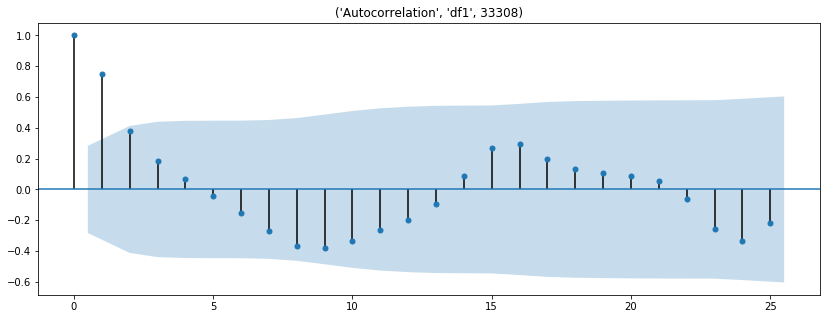

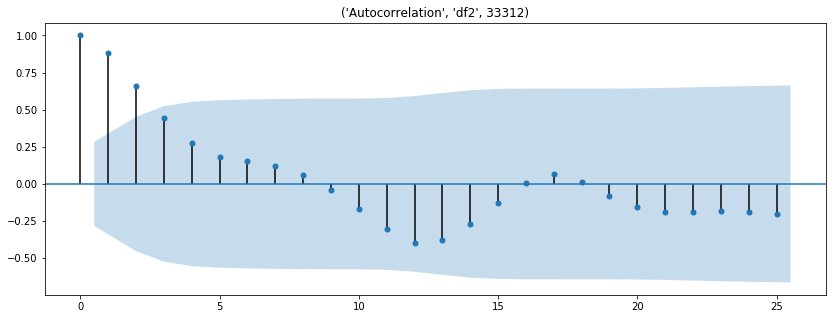

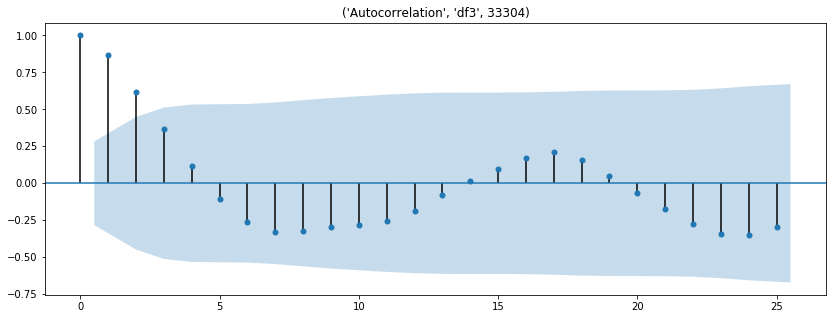

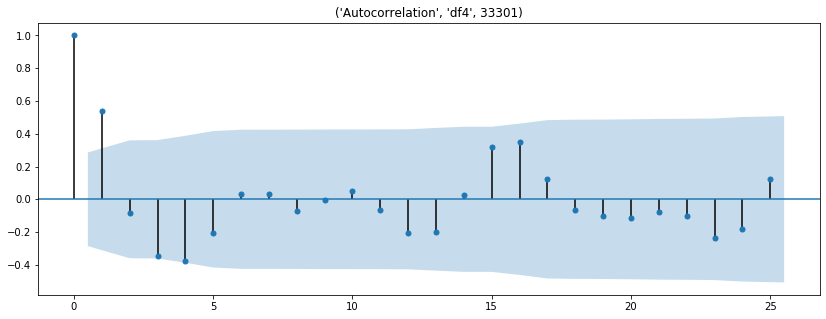

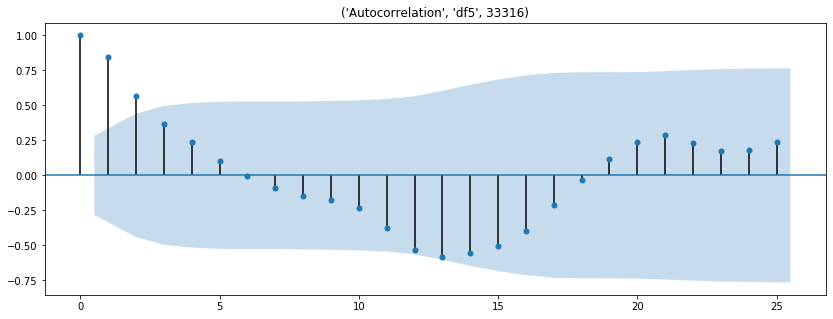

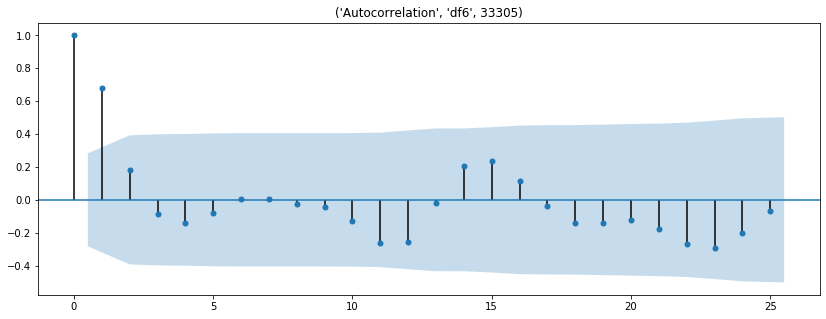

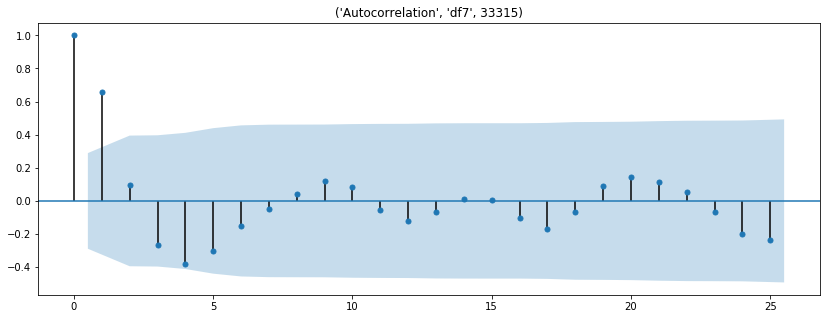

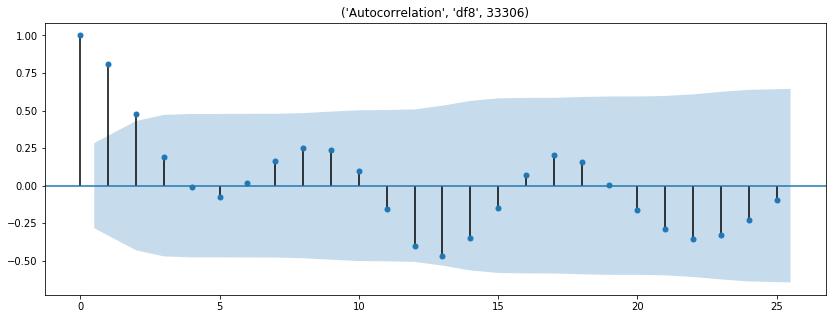

In [278]:
for n, d in enumerate(residuals):
    rcParams['figure.figsize'] = 14, 5
    titlezip = zipcodes[n]
    dfn = 'df' + str(n+1)
    if rezdiffs[n] != 0:
        plot_acf(d.diff(rezdiffs[n]).dropna(), lags=25, title=('Autocorrelation', dfn, titlezip))
    else:
        plot_acf(d, lags=25, title=('Autocorrelation', dfn, titlezip))

#### Residual MA conclusions

In [279]:
rez_mas = [1, 2, 2, 1, 1, 1, 1, 1]

## Partial auto-correlation plots

### Original

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


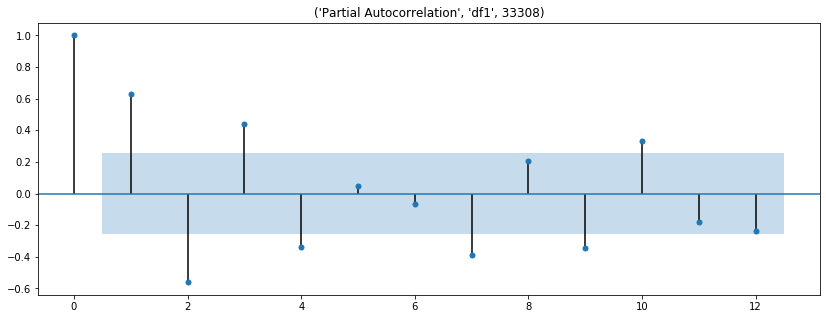

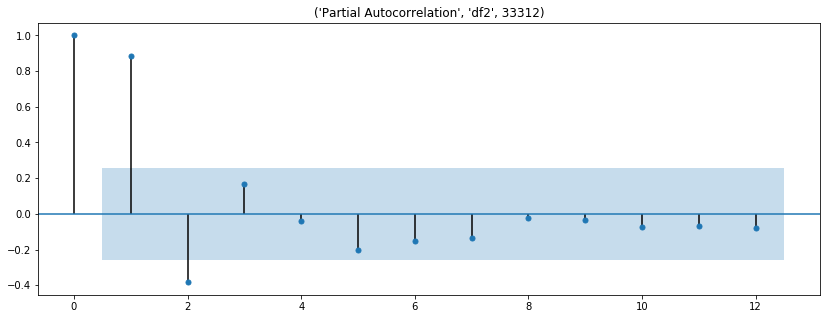

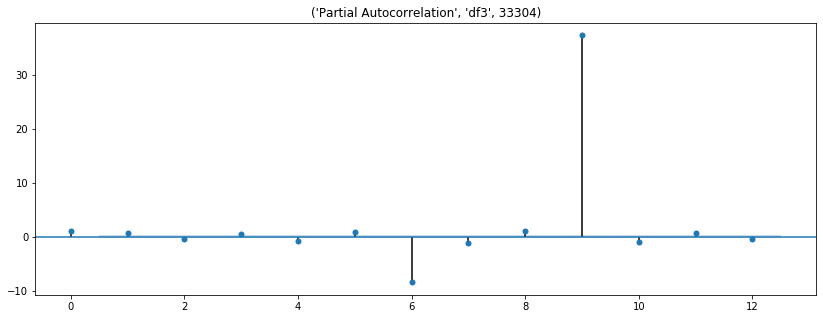

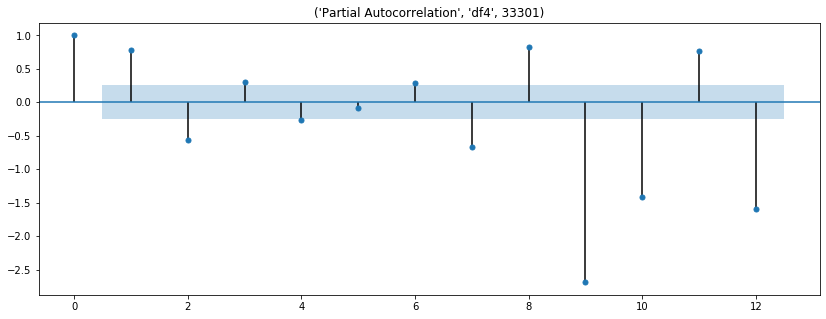

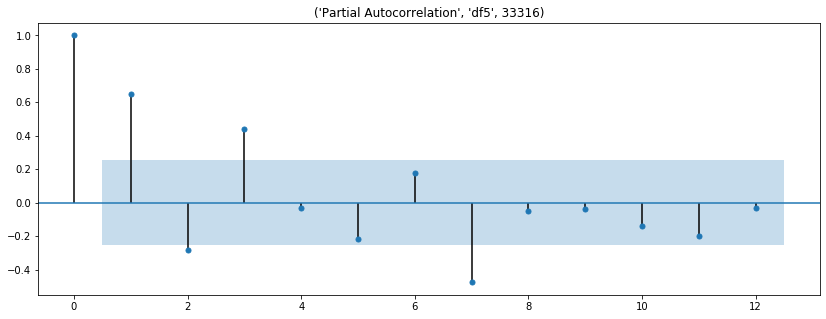

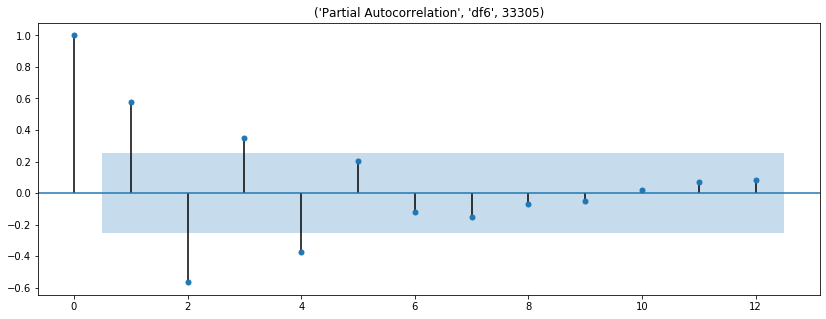

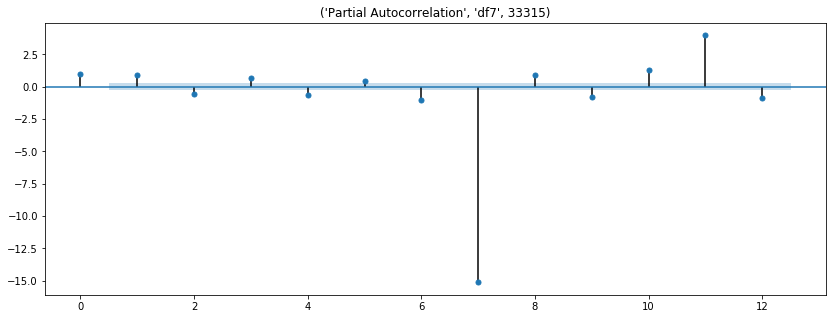

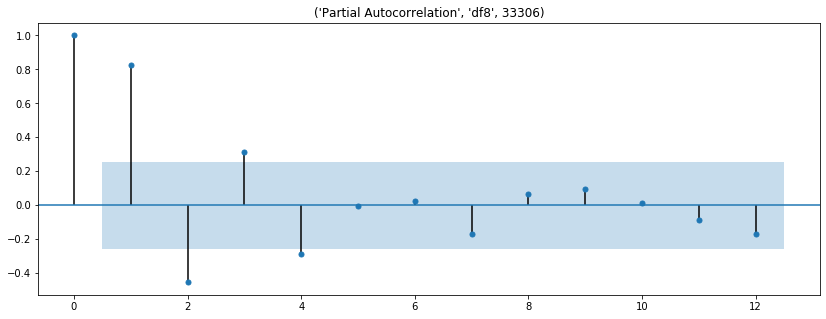

In [27]:
for n, d in enumerate(trdfs):
    rcParams['figure.figsize'] = 14, 5
    titlezip = zipcodes[n]
    dfn = 'df' + str(n+1)
    plot_pacf(d.diff(forced_diffs[n]).dropna(), lags=12, title=('Partial Autocorrelation', dfn, titlezip))

#### Original AR conclusions
(in the same order as the charts above)

- 2, 3, or 4
- 1 or 2
- ??
- 2 or 3
- 1, 2, or 3
- 1, 2, 3 or 4
- ??
- 1

In [28]:
ars = [4, 2, 1, 3, 3, 4, 1, 1]
ars_alt = [3, 1, 2, 2, 2, 3, 2, 1]

### Residual

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


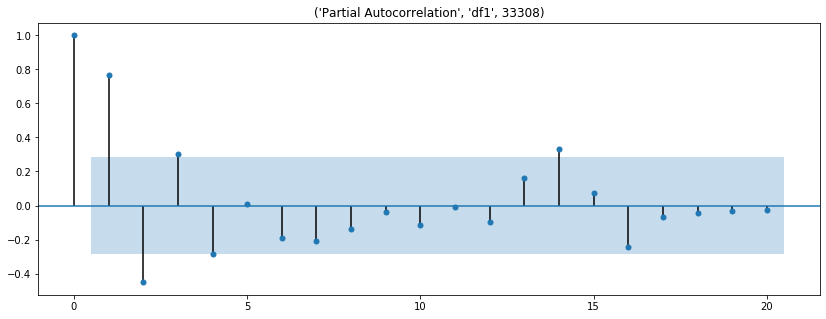

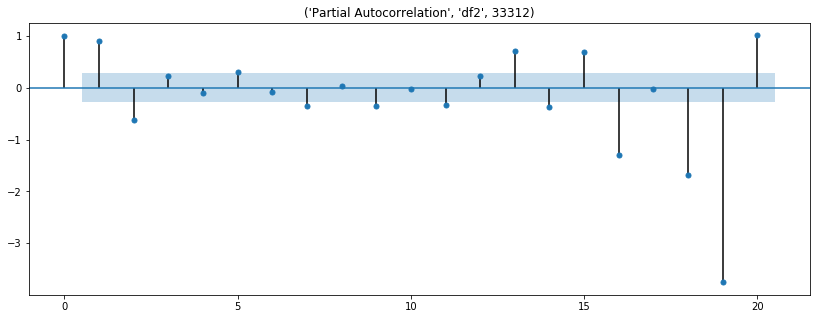

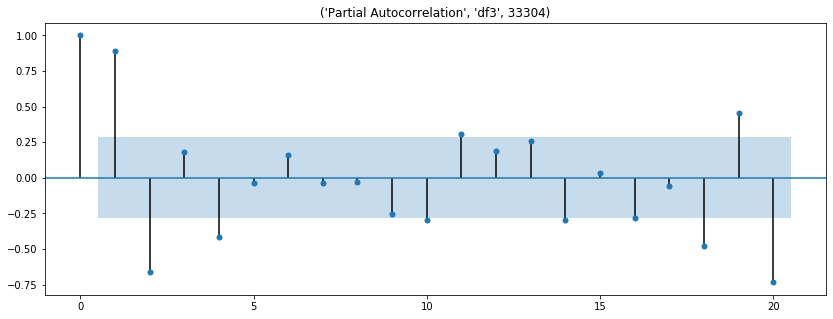

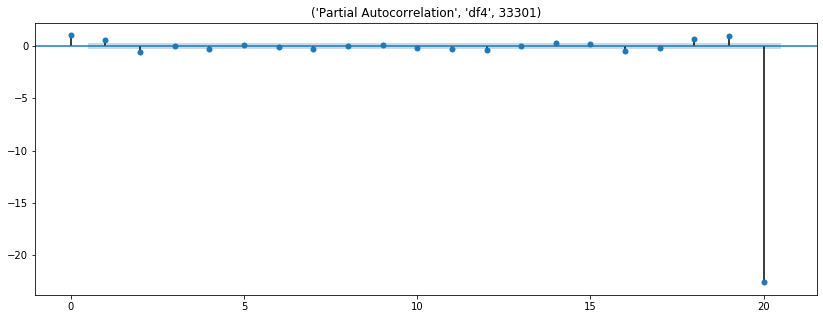

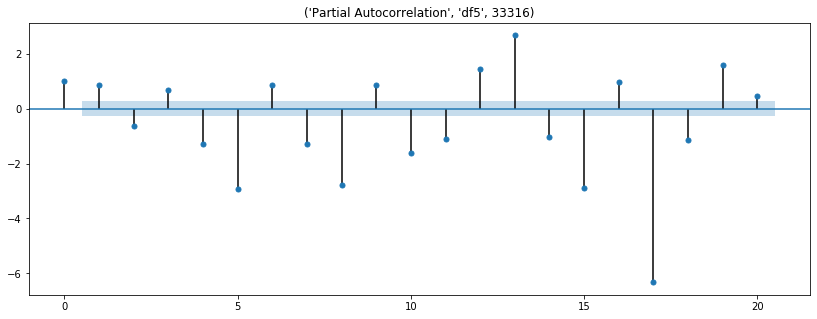

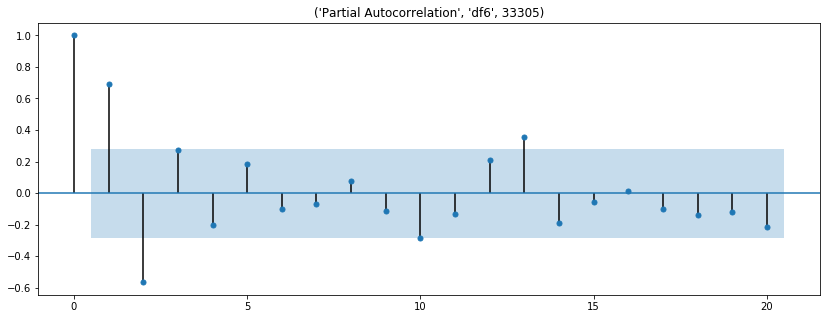

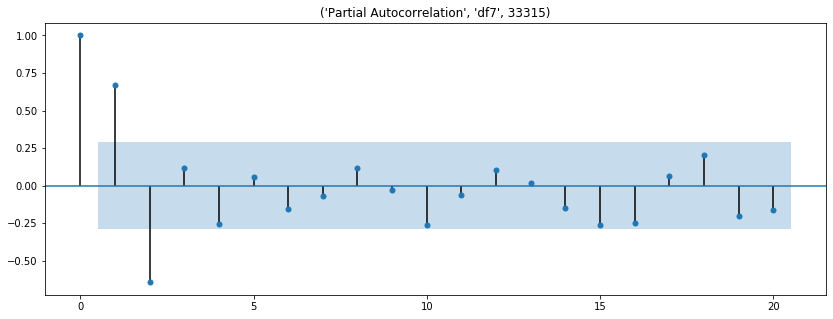

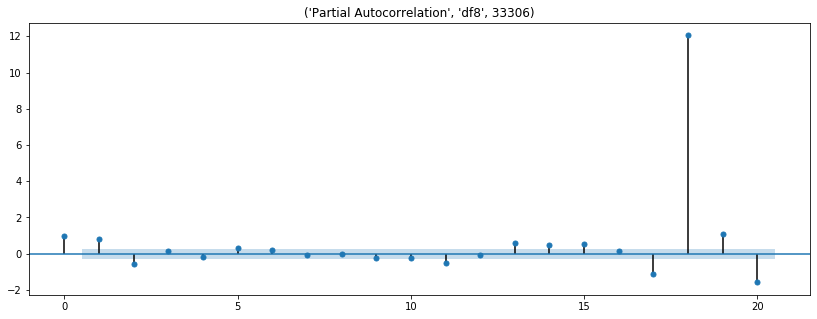

In [283]:
for n, d in enumerate(residuals):
    rcParams['figure.figsize'] = 14, 5
    titlezip = zipcodes[n]
    dfn = 'df' + str(n+1)
    if rezdiffs[n] != 0:
        plot_pacf(d.diff(rezdiffs[n]).dropna(), lags=20, title=('Partial Autocorrelation', dfn, titlezip))
    else:
        plot_pacf(d, lags=20, title=('Partial Autocorrelation', dfn, titlezip))

#### Residual AR conclusions

All of the PACF charts show cut-offs after 2 lags, EXCEPT for DF5 which doesn't have any cut-offs.

In [288]:
rez_ars = [2,2,2,2,2,2,2,2]

## EDA conclusions

- Since the ACF's of the residuals all show slow decay, while most of the PACF's of the residuals cut-off after 2 lags, the majority of these time series seem to be best-suited for first or second order AR models with annual seasonality accounted for
- Only DF's 4 and 7 need to be differenced in order for the residuals to achieve stationarity

# Step 5: ARIMA Modeling

## Baseline model: MA 

In [115]:
results = []

for n, df in enumerate(trdfs):
    arima_base = ARIMA(df, order=(0,0,1)).fit()
    
    start = len(df)
    end = len(df) + 15
    pred = arima_base.predict(start=start, end=end).rename('ARIMA Preds')
    
    rmse = np.sqrt(mean_squared_error(tedfs[n], pred))
    aic = arima_base.aic
    bic = arima_base.bic
    num = str(n+1)
    
    rez = ('trdf'+num, aic, bic, rmse)
    results.append(rez)

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/kevingiroux/opt/anaconda3/envs/le

In [116]:
for r in results:
    print(r[0], '  AIC:', round(r[1]), '   BIC:', round(r[2]), '   RMSE:', round(r[3]))

trdf1   AIC: 1429    BIC: 1436    RMSE: 97531
trdf2   AIC: 1341    BIC: 1347    RMSE: 88124
trdf3   AIC: 1417    BIC: 1423    RMSE: 95871
trdf4   AIC: 1535    BIC: 1541    RMSE: 212935
trdf5   AIC: 1536    BIC: 1542    RMSE: 188662
trdf6   AIC: 1414    BIC: 1420    RMSE: 110128
trdf7   AIC: 1376    BIC: 1382    RMSE: 88809
trdf8   AIC: 1440    BIC: 1446    RMSE: 135286


In [185]:
baseline_rez = []

for r in results:
    baseline_rez.append(round(r[3]))

## Manual tuning

### DF1 33308

In [395]:
model = ARIMA(trdf1, order=(2, 0, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -568.126
Date:                          Sun, 07 Mar 2021   AIC                           1142.252
Time:                                  13:07:14   BIC                           1147.865
Sample:                              01-01-2012   HQIC                          1144.373
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3785      0.467      0.811      0.418      -0.537       1.294
ar.L2          0.0285      0.470      0.061      0.952      -0.892       0.949
sigma2      1.141e+09   1.61e-10    7.1e+18      0.000    1.14e+09    1.14e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):              3077.91
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -6.04
Prob(H) (two-sided):                  0.01   Kurtosis:                        40.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+35. Standard errors may be unstable.
"""

In [396]:
start = len(trdf1)
end = len(trdf1) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf1, pred))
rmse

24194.57672735954

#### RMSE = 24,195

### DF2 33312

#### w/ seasonal order

In [414]:
model = ARIMA(trdf2, order=(1, 0, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -522.417
Date:                          Sun, 07 Mar 2021   AIC                           1048.833
Time:                                  13:19:53   BIC                           1052.576
Sample:                              01-01-2012   HQIC                          1050.247
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6626      0.020     33.003      0.000       0.623       0.702
sigma2      1.656e+08   3.45e-11   4.79e+18      0.000    1.66e+08    1.66e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):              3246.64
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -6.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        41.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [415]:
start = len(trdf2)
end = len(trdf2) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf2, pred))
rmse

42638.50766432795

#### w/o seasonal order

In [416]:
model = ARIMA(trdf2, order=(2, 0, 0)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -467.387
Date:                Sun, 07 Mar 2021   AIC                            942.774
Time:                        13:21:32   BIC                            951.151
Sample:                    01-01-2012   HQIC                           946.051
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.555e+05   2.58e-08   6.03e+12      0.000    1.55e+05    1.55e+05
ar.L1          1.9724      0.028     70.013      0.000       1.917       2.028
ar.L2         -0.9737      0.029    -33.938      0.000      -1.030      -0.917
sigma2       2.77e+05   2.12e-09   1.31e+14      0.000    2.77e+05    2.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.21   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.04   Prob(JB):                         0.30
Heteroskedasticity (H):               0.97   Skew:                            -0.44
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.65e+30. Standard errors may be unstable.
"""

In [417]:
start = len(trdf2)
end = len(trdf2) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf2, pred))
rmse

1507.9304059506624

#### RMSE = 1,508

### DF3 33304

In [418]:
model = ARIMA(trdf3, order=(2, 0, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -565.140
Date:                          Sun, 07 Mar 2021   AIC                           1136.279
Time:                                  13:22:20   BIC                           1141.893
Sample:                              01-01-2012   HQIC                          1138.400
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2805      0.072      3.893      0.000       0.139       0.422
ar.L2          0.2717      0.066      4.124      0.000       0.143       0.401
sigma2      1.292e+09   5.58e-12   2.32e+20      0.000    1.29e+09    1.29e+09
===================================================================================
Ljung-Box (L1) (Q):                  11.36   Jarque-Bera (JB):              1211.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -4.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.9e+35. Standard errors may be unstable.
"""

In [419]:
start = len(trdf3)
end = len(trdf3) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf3, pred))
rmse

19341.01654387188

#### RMSE = 19,341

### DF4 33301

#### w/ seasonal order

In [426]:
model = ARIMA(trdf4, order=(2, 1, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -620.545
Date:                          Sun, 07 Mar 2021   AIC                           1247.090
Time:                                  13:23:57   BIC                           1252.703
Sample:                              01-01-2012   HQIC                          1249.211
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.951      1.029      0.303      -0.885       2.843
ar.L2          0.0198      0.969      0.020      0.984      -1.879       1.919
sigma2      9.951e+09   1.56e-10   6.36e+19      0.000    9.95e+09    9.95e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3971.06
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -6.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        45.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.64e+35. Standard errors may be unstable.
"""

In [427]:
start = len(trdf4)
end = len(trdf4) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf4, pred))
rmse

91634.8672390438

#### w/o seasonal order

In [429]:
model = ARIMA(trdf4, order=(2, 1, 0)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -616.488
Date:                Sun, 07 Mar 2021   AIC                           1238.977
Time:                        13:24:23   BIC                           1245.209
Sample:                    01-01-2012   HQIC                          1241.410
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0196      0.018      1.087      0.277      -0.016       0.055
ar.L2          0.0139      0.021      0.652      0.514      -0.028       0.056
sigma2      6.966e+07   5.56e-12   1.25e+19      0.000    6.97e+07    6.97e+07
===================================================================================
Ljung-Box (L1) (Q):                  32.24   Jarque-Bera (JB):                 1.13
Prob(Q):                              0.00   Prob(JB):                         0.57
Heteroskedasticity (H):               1.16   Skew:                            -0.29
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.96e+34. Standard errors may be unstable.
"""

In [430]:
start = len(trdf4)
end = len(trdf4) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf4, pred))
rmse

13811.61579632342

#### RMSE = 13,812

### DF5 33316

In [433]:
model = ARIMA(trdf5, order=(2, 0, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -596.760
Date:                          Sun, 07 Mar 2021   AIC                           1199.520
Time:                                  13:25:25   BIC                           1205.134
Sample:                              01-01-2012   HQIC                          1201.641
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4569      1.290      0.354      0.723      -2.072       2.986
ar.L2          0.0404      1.316      0.031      0.975      -2.539       2.620
sigma2      3.681e+09   7.45e-10   4.94e+18      0.000    3.68e+09    3.68e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):              2488.51
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -5.59
Prob(H) (two-sided):                  0.01   Kurtosis:                        36.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.99e+34. Standard errors may be unstable.
"""

In [434]:
start = len(trdf5)
end = len(trdf5) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf5, pred))
rmse

36965.8144995083

#### RMSE = 36,966

### DF6 33305

#### w/ seasonal differencing

In [439]:
model = ARIMA(trdf6, order=(1, 0, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -557.998
Date:                          Sun, 07 Mar 2021   AIC                           1119.996
Time:                                  13:26:23   BIC                           1123.738
Sample:                              01-01-2012   HQIC                          1121.410
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4657      0.018     25.494      0.000       0.430       0.502
sigma2      7.319e+08   4.04e-12   1.81e+20      0.000    7.32e+08    7.32e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              3577.65
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -6.40
Prob(H) (two-sided):                  0.10   Kurtosis:                        43.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.14e+35. Standard errors may be unstable.
"""

In [440]:
start = len(trdf6)
end = len(trdf6) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf6, pred))
rmse

34065.622509196575

#### w/o seasonal differencing

In [441]:
model = ARIMA(trdf6, order=(1, 0, 0)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -583.676
Date:                Sun, 07 Mar 2021   AIC                           1173.351
Time:                        13:27:06   BIC                           1179.634
Sample:                    01-01-2012   HQIC                          1175.809
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.022e+05   9.81e+04      4.100      0.000     2.1e+05    5.95e+05
ar.L1          0.9993      0.008    124.767      0.000       0.984       1.015
sigma2      1.479e+07    121.543   1.22e+05      0.000    1.48e+07    1.48e+07
===================================================================================
Ljung-Box (L1) (Q):                  11.19   Jarque-Bera (JB):                13.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                            -0.67
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.65e+21. Standard errors may be unstable.
"""

In [442]:
start = len(trdf6)
end = len(trdf6) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf6, pred))
rmse

14443.9956520287

#### RMSE = 14,444

### DF7 33315

In [447]:
model = ARIMA(trdf7, order=(1, 2, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(1, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -389.173
Date:                          Sun, 07 Mar 2021   AIC                            782.345
Time:                                  13:28:11   BIC                            786.002
Sample:                              01-01-2012   HQIC                           783.715
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0166      0.076      0.220      0.826      -0.132       0.165
sigma2      1.246e+06   3.08e+05      4.053      0.000    6.44e+05    1.85e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.25   Jarque-Bera (JB):                 1.47
Prob(Q):                              0.07   Prob(JB):                         0.48
Heteroskedasticity (H):               0.99   Skew:                             0.39
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [448]:
start = len(trdf7)
end = len(trdf7) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf7, pred))
rmse

4002.091122407367

#### RMSE = 4,002

### DF8 33306

#### w/ seasonal order

In [453]:
model = ARIMA(trdf8, order=(2, 0, 0), seasonal_order=(0,1,0,12)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/kevingiroux/opt/

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                           Actual   No. Observations:                   60
Model:             ARIMA(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -576.563
Date:                          Sun, 07 Mar 2021   AIC                           1159.127
Time:                                  13:30:17   BIC                           1164.740
Sample:                              01-01-2012   HQIC                          1161.248
                                   - 12-01-2016                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7253      0.045     16.163      0.000       0.637       0.813
ar.L2         -0.2544      0.037     -6.880      0.000      -0.327      -0.182
sigma2      1.659e+09   1.19e-11   1.39e+20      0.000    1.66e+09    1.66e+09
===================================================================================
Ljung-Box (L1) (Q):                   5.50   Jarque-Bera (JB):              1499.26
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -4.02
Prob(H) (two-sided):                  0.02   Kurtosis:                        29.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.07e+36. Standard errors may be unstable.
"""

In [454]:
start = len(trdf8)
end = len(trdf8) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf8, pred))
rmse

55070.053551484

#### w/o seasonal order

In [461]:
model = ARIMA(trdf8, order=(1, 0, 0)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -601.935
Date:                Sun, 07 Mar 2021   AIC                           1209.869
Time:                        13:32:30   BIC                           1216.152
Sample:                    01-01-2012   HQIC                          1212.327
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.982e+05    1.3e-10   3.82e+15      0.000    4.98e+05    4.98e+05
ar.L1          0.9992      0.005    206.396      0.000       0.990       1.009
sigma2      2.619e+07   1.42e-12   1.85e+19      0.000    2.62e+07    2.62e+07
===================================================================================
Ljung-Box (L1) (Q):                  31.61   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.00   Prob(JB):                         0.95
Heteroskedasticity (H):               1.78   Skew:                             0.10
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.1e+35. Standard errors may be unstable.
"""

In [462]:
start = len(trdf8)
end = len(trdf8) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf8, pred))
rmse

13901.005021022616

#### RMSE = 13,901

### Appendix

In [187]:
manual_rez = [33883, 11333, 24169, 72780, 39835, 18734, 6980, 55272]

In [46]:
ars

[4, 2, 1, 3, 3, 4, 1, 1]

In [47]:
forced_diffs

[1, 2, 1, 1, 1, 1, 2, 2]

In [48]:
mas

[1, 3, 2, 1, 1, 1, 3, 2]

In [49]:
zipcodes

[33308, 33312, 33304, 33301, 33316, 33305, 33315, 33306]

In [52]:
def arimodel(train, test, ps, ds, qs):
    
    results = []
    
    for n, df in enumerate(train):
        arima_base = ARIMA(df, order=(ps[n],ds[n],qs[n])).fit()
    
        start = len(df)
        end = len(df) + 15
        pred = arima_base.predict(start=start, end=end).rename('ARIMA Preds')
    
        rmse = np.sqrt(mean_squared_error(test[n], pred))
        aic = arima_base.aic
        bic = arima_base.bic
        num = str(n+1)
    
        rez = ('trdf'+num, aic, bic, rmse)
        results.append(rez)
        
    return(results)

In [117]:
model = ARIMA(trdf1, order=(4, 1, 1)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -553.016
Date:                Sat, 06 Mar 2021   AIC                           1118.033
Time:                        18:50:19   BIC                           1130.498
Sample:                    01-01-2012   HQIC                          1122.899
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.012     84.707      0.000       0.974       1.020
ar.L2          0.0060      0.054      0.110      0.912      -0.100       0.112
ar.L3          0.0001      0.077      0.002      0.999      -0.150       0.151
ar.L4         -0.0045      0.039     -0.114      0.909      -0.082       0.073
ma.L1         -0.9932      0.005   -193.532      0.000      -1.003      -0.983
sigma2      2.072e+06   9.05e-09   2.29e+14      0.000    2.07e+06    2.07e+06
===================================================================================
Ljung-Box (L1) (Q):                  23.58   Jarque-Bera (JB):                 4.18
Prob(Q):                              0.00   Prob(JB):                         0.12
Heteroskedasticity (H):               0.59   Skew:                             0.53
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.07e+29. Standard errors may be unstable.
"""

In [118]:
start = len(trdf1)
end = len(trdf1) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf1, pred))
rmse

33882.74590214998

In [119]:
model = ARIMA(trdf2, order=(2, 2, 2)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -441.114
Date:                Sat, 06 Mar 2021   AIC                            892.227
Time:                        18:50:53   BIC                            902.529
Sample:                    01-01-2012   HQIC                           896.240
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7443      0.152      4.907      0.000       0.447       1.042
ar.L2         -0.7827      0.141     -5.546      0.000      -1.059      -0.506
ma.L1         -0.7840      0.160     -4.888      0.000      -1.098      -0.470
ma.L2          0.7625      0.161      4.742      0.000       0.447       1.078
sigma2      2.294e+05   5.04e+04      4.550      0.000    1.31e+05    3.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.49   Jarque-Bera (JB):                 2.96
Prob(Q):                              0.06   Prob(JB):                         0.23
Heteroskedasticity (H):               1.25   Skew:                            -0.54
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
start = len(trdf2)
end = len(trdf2) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf2, pred))
rmse

11332.64906500402

In [121]:
model = ARIMA(trdf3, order=(1, 1, 2)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -579.063
Date:                Sat, 06 Mar 2021   AIC                           1166.125
Time:                        18:52:33   BIC                           1174.436
Sample:                    01-01-2012   HQIC                          1169.369
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9934      0.002    435.339      0.000       0.989       0.998
ma.L1         -0.9776      0.008   -122.690      0.000      -0.993      -0.962
ma.L2         -0.0045      0.007     -0.633      0.527      -0.018       0.009
sigma2      1.526e+06   4.16e-10   3.66e+15      0.000    1.53e+06    1.53e+06
===================================================================================
Ljung-Box (L1) (Q):                  38.32   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               0.33   Skew:                             0.37
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.77e+30. Standard errors may be unstable.
"""

In [122]:
start = len(trdf3)
end = len(trdf3) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf3, pred))
rmse

24169.150054756792

In [123]:
model = ARIMA(trdf4, order=(3, 1, 1)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -615.277
Date:                Sat, 06 Mar 2021   AIC                           1240.553
Time:                        18:52:52   BIC                           1250.941
Sample:                    01-01-2012   HQIC                          1244.608
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0049      0.007    135.265      0.000       0.990       1.019
ar.L2         -0.0067      0.018     -0.367      0.714      -0.043       0.029
ar.L3          0.0016      0.016      0.101      0.919      -0.030       0.033
ma.L1         -0.9979      0.009   -108.710      0.000      -1.016      -0.980
sigma2      7.858e+06   9.87e-11   7.96e+16      0.000    7.86e+06    7.86e+06
===================================================================================
Ljung-Box (L1) (Q):                  36.47   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.00   Prob(JB):                         0.81
Heteroskedasticity (H):               0.66   Skew:                            -0.15
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+33. Standard errors may be unstable.
"""

In [124]:
start = len(trdf4)
end = len(trdf4) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf4, pred))
rmse

72780.18617028442

In [244]:
model = ARIMA(trdf5, order=(3, 1, 1)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -602.080
Date:                Sun, 07 Mar 2021   AIC                           1214.161
Time:                        11:08:09   BIC                           1224.549
Sample:                    01-01-2012   HQIC                          1218.216
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9950      0.011     88.164      0.000       0.973       1.017
ar.L2         -0.0056      0.028     -0.199      0.842      -0.061       0.050
ar.L3          0.0082      0.025      0.323      0.746      -0.042       0.058
ma.L1         -0.9921      0.005   -181.796      0.000      -1.003      -0.981
sigma2       1.05e+07   2.17e-10   4.84e+16      0.000    1.05e+07    1.05e+07
===================================================================================
Ljung-Box (L1) (Q):                  24.70   Jarque-Bera (JB):                 2.89
Prob(Q):                              0.00   Prob(JB):                         0.24
Heteroskedasticity (H):               0.60   Skew:                             0.54
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+32. Standard errors may be unstable.
"""

In [245]:
start = len(trdf5)
end = len(trdf5) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf5, pred))
rmse

39835.1554005589

In [127]:
model = ARIMA(trdf6, order=(4, 1, 1)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -530.272
Date:                Sat, 06 Mar 2021   AIC                           1072.545
Time:                        18:53:58   BIC                           1085.010
Sample:                    01-01-2012   HQIC                          1077.411
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0070      0.016     63.218      0.000       0.976       1.038
ar.L2          0.0118      0.043      0.274      0.784      -0.073       0.096
ar.L3          0.0033      0.046      0.071      0.943      -0.088       0.094
ar.L4         -0.0223      0.023     -0.955      0.339      -0.068       0.023
ma.L1         -0.9969      0.011    -94.924      0.000      -1.018      -0.976
sigma2      1.251e+06   6.51e-09   1.92e+14      0.000    1.25e+06    1.25e+06
===================================================================================
Ljung-Box (L1) (Q):                  15.23   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               1.01   Skew:                            -0.17
Prob(H) (two-sided):                  0.98   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.16e+29. Standard errors may be unstable.
"""

In [128]:
start = len(trdf6)
end = len(trdf6) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf6, pred))
rmse

18733.825875038012

In [129]:
model = ARIMA(trdf7, order=(1, 2, 3)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -467.723
Date:                Sat, 06 Mar 2021   AIC                            945.446
Time:                        18:54:06   BIC                            955.748
Sample:                    01-01-2012   HQIC                           949.459
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0697      3.218     -0.022      0.983      -6.378       6.238
ma.L1          0.0711      3.223      0.022      0.982      -6.245       6.388
ma.L2         -0.0104      0.061     -0.170      0.865      -0.131       0.110
ma.L3         -0.0122      0.047     -0.256      0.798      -0.105       0.081
sigma2      5.867e+05   1.31e+05      4.473      0.000     3.3e+05    8.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.94   Jarque-Bera (JB):                 1.03
Prob(Q):                              0.09   Prob(JB):                         0.60
Heteroskedasticity (H):               1.37   Skew:                             0.30
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [130]:
start = len(trdf7)
end = len(trdf7) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf7, pred))
rmse

6980.237812949773

In [131]:
model = ARIMA(trdf8, order=(3, 1, 2)).fit()
model.summary()

/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kevingiroux/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Actual   No. Observations:                   60
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -605.003
Date:                Sat, 06 Mar 2021   AIC                           1222.007
Time:                        18:54:18   BIC                           1234.472
Sample:                    01-01-2012   HQIC                          1226.873
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0094      0.005     -1.781      0.075      -0.020       0.001
ar.L2          0.9998      0.000   5266.582      0.000       0.999       1.000
ar.L3          0.0096      0.006      1.743      0.081      -0.001       0.020
ma.L1          0.0001      0.105      0.001      0.999      -0.205       0.205
ma.L2         -0.9999      0.039    -25.563      0.000      -1.077      -0.923
sigma2      1.876e+06   7.85e-08   2.39e+13      0.000    1.88e+06    1.88e+06
===================================================================================
Ljung-Box (L1) (Q):                  36.75   Jarque-Bera (JB):                 2.44
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               1.55   Skew:                             0.42
Prob(H) (two-sided):                  0.33   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.11e+28. Standard errors may be unstable.
"""

In [132]:
start = len(trdf8)
end = len(trdf8) + 15
pred = model.predict(start=start, end=end, typ='levels').rename('ARIMA Preds')
rmse = np.sqrt(mean_squared_error(tedf8, pred))
rmse

55272.216257561326

## Auto-ARIMA

### DF1 33308

In [481]:
model1 = auto_arima(trdf1, start_p=0, d=0, start_q=0, max_p=5, max_d=5, max_q=5, error_action='ignore')
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -528.241
Date:                Sun, 07 Mar 2021   AIC                           1068.482
Time:                        13:55:54   BIC                           1081.048
Sample:                             0   HQIC                          1073.398
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2146.7153   1211.238      1.772      0.076    -227.267    4520.698
ar.L1          2.3848      0.093     25.533      0.000       2.202       2.568
ar.L2         -2.4112      0.231    -10.447      0.000      -2.864      -1.959
ar.L3          1.6166      0.244      6.616      0.000       1.138       2.096
ar.L4         -0.5945      0.104     -5.721      0.000      -0.798      -0.391
sigma2      1.833e+06      1.488   1.23e+06      0.000    1.83e+06    1.83e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 1.21
Prob(Q):                              0.56   Prob(JB):                         0.54
Heteroskedasticity (H):               0.91   Skew:                             0.35
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+21. Standard errors may be unstable.
"""

In [473]:
pred = model1.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf1, pred))
rmse

19821.821407924628

In [615]:
model1.fit(df1)
forecast1, confint1 = model1.predict(24, return_conf_int=True)

lowers1 = []
uppers1 = []

for i in confint1:
    lowers1.append(i[0])
    uppers1.append(i[1])

#### RMSE = 19,822

### DF2 33312

In [495]:
model2 = auto_arima(trdf2, start_p=0, start_q=0, max_p=5, max_d=20, max_q=5, error_action='ignore')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -495.318
Date:                Sun, 07 Mar 2021   AIC                            998.636
Time:                        14:14:42   BIC                           1006.946
Sample:                             0   HQIC                          1001.880
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    207.0357    120.141      1.723      0.085     -28.435     442.507
ar.L1          0.9021      0.059     15.256      0.000       0.786       1.018
ma.L1         -0.9416      0.049    -19.190      0.000      -1.038      -0.845
sigma2      1.196e+06      0.016   7.72e+07      0.000     1.2e+06     1.2e+06
===================================================================================
Ljung-Box (L1) (Q):                  44.78   Jarque-Bera (JB):                 3.33
Prob(Q):                              0.00   Prob(JB):                         0.19
Heteroskedasticity (H):               1.78   Skew:                             0.48
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.67e+24. Standard errors may be unstable.
"""

In [496]:
pred = model2.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf2, pred))
rmse

9424.274819971923

In [614]:
model2.fit(df2)
forecast2, confint2 = model2.predict(24, return_conf_int=True)

lowers2 = []
uppers2 = []

for i in confint2:
    lowers2.append(i[0])
    uppers2.append(i[1])

#### RMSE = 9,424

### DF3 33304

In [521]:
model3 = auto_arima(trdf3, start_p=0, d=0, start_q=0, max_p=5, max_q=5, D=1, m=12, error_action='ignore')
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -529.273
Date:                  Sun, 07 Mar 2021   AIC                           1062.546
Time:                          14:20:06   BIC                           1066.289
Sample:                               0   HQIC                          1063.961
                                   - 60                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    3.94e+04   2426.072     16.242      0.000    3.46e+04    4.42e+04
sigma2      2.213e+08    7.2e+07      3.076      0.002    8.03e+07    3.62e+08
===================================================================================
Ljung-Box (L1) (Q):                  45.33   Jarque-Bera (JB):                 3.72
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               0.30   Skew:                             0.47
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [522]:
pred = model3.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf3, pred))
rmse

27573.39975650347

In [613]:
model3.fit(df3)
forecast3, confint3 = model3.predict(24, return_conf_int=True)

lowers3 = []
uppers3 = []

for i in confint3:
    lowers3.append(i[0])
    uppers3.append(i[1])

#### RMSE = 27,573

### DF4 33301

In [529]:
model4 = auto_arima(trdf4, start_p=0, d=0, start_q=0, max_p=5, max_q=5, D=1, m=12, error_action='ignore')
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -555.708
Date:                  Sun, 07 Mar 2021   AIC                           1115.416
Time:                          14:21:20   BIC                           1119.158
Sample:                               0   HQIC                          1116.830
                                   - 60                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    8.58e+04   3744.995     22.911      0.000    7.85e+04    9.31e+04
sigma2      6.659e+08   2.33e+08      2.853      0.004    2.08e+08    1.12e+09
===================================================================================
Ljung-Box (L1) (Q):                  45.88   Jarque-Bera (JB):                 3.51
Prob(Q):                              0.00   Prob(JB):                         0.17
Heteroskedasticity (H):               1.00   Skew:                             0.09
Prob(H) (two-sided):                  0.99   Kurtosis:                         1.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [530]:
pred = model4.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf4, pred))
rmse

66829.54529996445

In [612]:
model4.fit(df4)
forecast4, confint4 = model4.predict(24, return_conf_int=True)

lowers4 = []
uppers4 = []

for i in confint4:
    lowers4.append(i[0])
    uppers4.append(i[1])

#### RMSE = 66,830

### DF5 33316

In [537]:
model5 = auto_arima(trdf5, start_p=0, start_q=0, max_p=5, max_d=5, max_q=5, error_action='ignore')
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -586.836
Date:                Sun, 07 Mar 2021   AIC                           1177.672
Time:                        14:24:38   BIC                           1181.827
Sample:                             0   HQIC                          1179.294
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6149.1525    722.068      8.516      0.000    4733.925    7564.380
sigma2      2.552e+07   5.26e+06      4.851      0.000    1.52e+07    3.58e+07
===================================================================================
Ljung-Box (L1) (Q):                  25.42   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               0.59   Skew:                             0.57
Prob(H) (two-sided):                  0.25   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [538]:
pred = model5.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf5, pred))
rmse

43130.131767742416

In [611]:
model5.fit(df5)
forecast5, confint5 = model5.predict(24, return_conf_int=True)

lowers5 = []
uppers5 = []

for i in confint5:
    lowers5.append(i[0])
    uppers5.append(i[1])

#### RMSE = 43,130

### DF6 33305

In [545]:
model6 = auto_arima(trdf6, start_p=0, d=0, start_q=0, max_p=5, max_q=5, D=1, m=12, error_action='ignore')
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -483.743
Date:                  Sun, 07 Mar 2021   AIC                            971.486
Time:                          14:26:43   BIC                            975.229
Sample:                               0   HQIC                           972.901
                                   - 60                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.939e+04    834.000     47.230      0.000    3.78e+04     4.1e+04
sigma2       3.32e+07   7.34e+06      4.525      0.000    1.88e+07    4.76e+07
===================================================================================
Ljung-Box (L1) (Q):                  41.48   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               3.56   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [546]:
pred = model6.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf6, pred))
rmse

14733.72538923837

In [610]:
model6.fit(df6)
forecast6, confint6 = model6.predict(24, return_conf_int=True)

lowers6 = []
uppers6 = []

for i in confint6:
    lowers6.append(i[0])
    uppers6.append(i[1])

#### RMSE = 14,734

### DF7 33315

In [554]:
model7 = auto_arima(trdf7, start_p=0, start_q=0, max_p=5, max_d=5, max_q=5, error_action='ignore')
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -500.982
Date:                Sun, 07 Mar 2021   AIC                           1009.963
Time:                        14:29:27   BIC                           1018.273
Sample:                             0   HQIC                          1013.207
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    323.4716    220.629      1.466      0.143    -108.954     755.897
ar.L1          0.8750      0.094      9.308      0.000       0.691       1.059
ma.L1         -0.9070      0.081    -11.198      0.000      -1.066      -0.748
sigma2      1.433e+06      0.012   1.18e+08      0.000    1.43e+06    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                  38.70   Jarque-Bera (JB):                 2.23
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               0.52   Skew:                            -0.31
Prob(H) (two-sided):                  0.15   Kurtosis:                         2.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.72e+25. Standard errors may be unstable.
"""

In [555]:
pred = model7.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf7, pred))
rmse

7357.425596789389

In [609]:
model7.fit(df7)
forecast7, confint7 = model7.predict(24, return_conf_int=True)

lowers7 = []
uppers7 = []

for i in confint7:
    lowers7.append(i[0])
    uppers7.append(i[1])

#### RMSE = 7,357

### DF8 33306

In [563]:
model8 = auto_arima(trdf8, start_p=0, d=0, start_q=0, max_p=5, max_d=5, max_q=5, D=1, m=12, error_action='ignore')
model8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -526.576
Date:                  Sun, 07 Mar 2021   AIC                           1057.152
Time:                          14:30:42   BIC                           1060.895
Sample:                               0   HQIC                          1058.567
                                   - 60                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.888e+04   2551.537     19.157      0.000    4.39e+04    5.39e+04
sigma2      1.978e+08   4.67e+07      4.234      0.000    1.06e+08    2.89e+08
===================================================================================
Ljung-Box (L1) (Q):                  37.24   Jarque-Bera (JB):                 7.19
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               2.38   Skew:                             0.93
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [564]:
pred = model8.predict(n_periods=16)
rmse = np.sqrt(mean_squared_error(tedf8, pred))
rmse

38934.399009298715

In [640]:
model8.fit(df8)
forecast8, confint8 = model8.predict(24, return_conf_int=True)

lowers8 = []
uppers8 = []

for i in confint8:
    lowers8.append(i[0])
    uppers8.append(i[1])
    
lowers8 = pd.Series(lowers8, index=())

#### RMSE = 38,934

### Appendix

In [568]:
final_rez = [19822, 9424, 27573, 66830, 43130, 14734, 7357, 38934]

# Questions for Analysis

## Forecast visualizations

In [648]:
us = [uppers1, uppers2, uppers3, uppers4, uppers5, uppers6, uppers7, uppers8]
ls = [lowers1, lowers2, lowers3, lowers4, lowers5, lowers6, lowers7, lowers8]
fs = [forecast1, forecast2, forecast3, forecast4, forecast5, forecast6, forecast7, forecast8]
ns = [1,2,3,4,5,6,7,8]

In [745]:
forecastdates = ['2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', 
 '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', 
 '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', ]

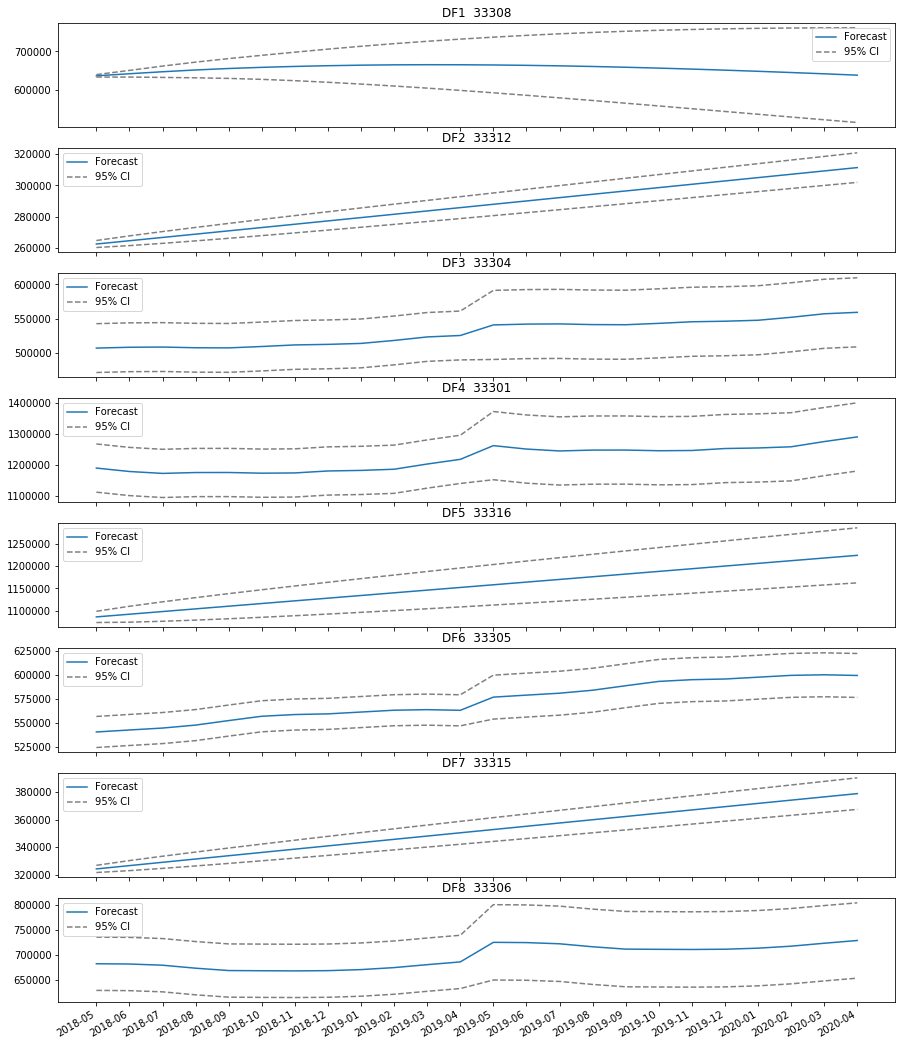

In [747]:
plt.figure(figsize=(15,20))

for f, l, u, n in zip(fs, ls, us, ns):
    sub = '81' + str(n)
    plt.subplot(sub)
    plt.plot(f, label='Forecast')
    plt.plot(l, c='grey', label='95% CI', ls="--")
    plt.plot(u, c='grey', ls="--")
    plt.title('DF'+str(n)+'  '+str(zipcodes[n-1]))
    plt.xticks(ticks=range(len(f)), labels=forecastdates)
    plt.legend()
plt.gcf().autofmt_xdate()

## Q1:  Least risky zipcode?
NOTE: Risk is calculated as the one-sided range of the confidence interval divided by the final forecasted price.

In [686]:
# LEAST RISKY (aka smallest confidence interval as a percentage of final forecasted price in period 24)

risks = []

for n, i in enumerate(fs):
    var = (us[n][23] - ls[n][23])/2
    price = i[23]
    relative_risk = var/price
    risks.append(round(relative_risk,3))
    
    num = n+1
    z = zipcodes[n]
    print('DF', num, z, round(relative_risk,3))

DF 1 33308 0.194
DF 2 33312 0.031
DF 3 33304 0.09
DF 4 33301 0.085
DF 5 33316 0.051
DF 6 33305 0.038
DF 7 33315 0.03
DF 8 33306 0.104


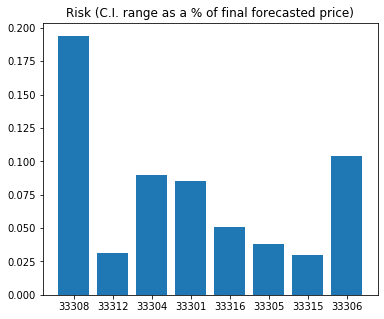

In [713]:
plt.figure(figsize=(6,5))
plt.bar(range(0,8,1), risks)
plt.xticks(ticks=range(0,8,1), labels=zipcodes)
plt.title('Risk (C.I. range as a % of final forecasted price)');

### Conclusion:  DF7 / 33315 @ 3%

## Q2: Greatest nominal change in price?

In [685]:
changes = []

for n, i in enumerate(fs):
    startprice = i[0]
    endprice = i[23]
    change = endprice-startprice
    changes.append(round(change))
    
    num = n+1
    z = zipcodes[n]
    print('DF', num, z, round(change))

DF 1 33308 1757
DF 2 33312 49099
DF 3 33304 51933
DF 4 33301 100064
DF 5 33316 138552
DF 6 33305 58948
DF 7 33315 54417
DF 8 33306 46667


''

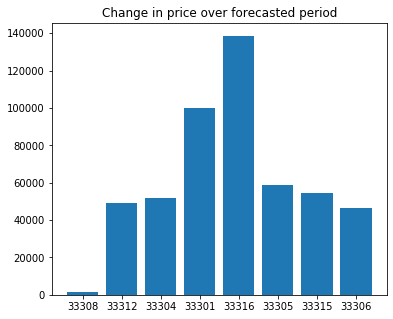

In [714]:
plt.figure(figsize=(6,5))
plt.bar(range(0,8,1), changes)
plt.xticks(ticks=range(0,8,1), labels=zipcodes)
plt.title('Change in price over forecasted period')
;

### Conclusions: DF5 / 33316 @ $138,552

## Q3: Best ROI (based on forecasted price)?

In [682]:
rois = []

for n, i in enumerate(fs):
    startprice = i[0]
    endprice = i[23]
    diff = endprice-startprice
    roi = diff/startprice
    rois.append(round(roi,2))

    num = n+1
    z = zipcodes[n]
    print('DF', num, z, round(roi,2))

DF 1 33308 0.0
DF 2 33312 0.19
DF 3 33304 0.1
DF 4 33301 0.08
DF 5 33316 0.13
DF 6 33305 0.11
DF 7 33315 0.17
DF 8 33306 0.07


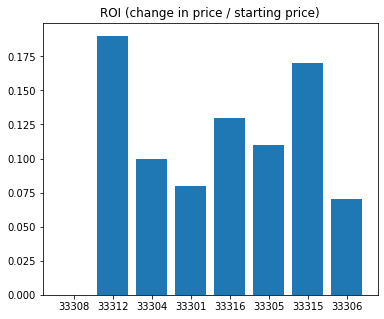

In [715]:
plt.figure(figsize=(6,5))
plt.bar(range(0,8,1), rois)
plt.xticks(ticks=range(0,8,1), labels=zipcodes)
plt.title('ROI (change in price / starting price)');

### Conclusions: DF2 / 33312 @ 19%

# Questions

- it seems like my model does the best without any differencing
- my model wont run with a differencing value higher than 2

# Appendix

In [760]:
forecast2 = pd.Series(forecast2, index=forecastdates)
forecast4 = pd.Series(forecast4, index=forecastdates)
forecast5 = pd.Series(forecast5, index=forecastdates)
forecast7 = pd.Series(forecast7, index=forecastdates)

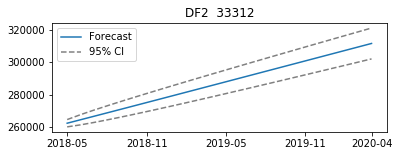

In [781]:
plt.figure(figsize=(6,2))
plt.plot(forecast2, label='Forecast')
plt.plot(lowers2, c='grey', label='95% CI', ls="--")
plt.plot(uppers2, c='grey', ls="--")
plt.title('DF'+str(2)+'  '+str(33312))
plt.legend()
plt.xticks(ticks=[0,6,12,18,23]);

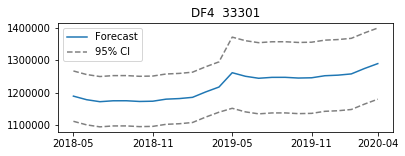

In [780]:
plt.figure(figsize=(6,2))
plt.plot(forecast4, label='Forecast')
plt.plot(lowers4, c='grey', label='95% CI', ls="--")
plt.plot(uppers4, c='grey', ls="--")
plt.title('DF'+str(4)+'  '+str(33301))
plt.legend()
plt.xticks(ticks=[0,6,12,18,23]);

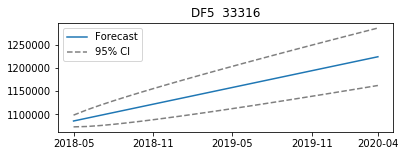

In [777]:
plt.figure(figsize=(6,2))
plt.plot(forecast5, label='Forecast')
plt.plot(lowers5, c='grey', label='95% CI', ls="--")
plt.plot(uppers5, c='grey', ls="--")
plt.title('DF'+str(5)+'  '+str(33316))
plt.xticks(ticks=[0,6,12,18,23])
plt.legend();

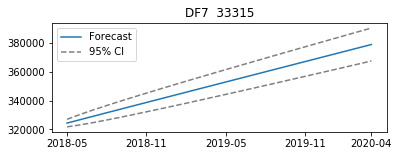

In [778]:
plt.figure(figsize=(6,2))
plt.plot(forecast7, label='Forecast')
plt.plot(lowers7, c='grey', label='95% CI', ls="--")
plt.plot(uppers7, c='grey', ls="--")
plt.title('DF'+str(7)+'  '+str(33315))
plt.xticks(ticks=[0,6,12,18,23])
plt.legend();

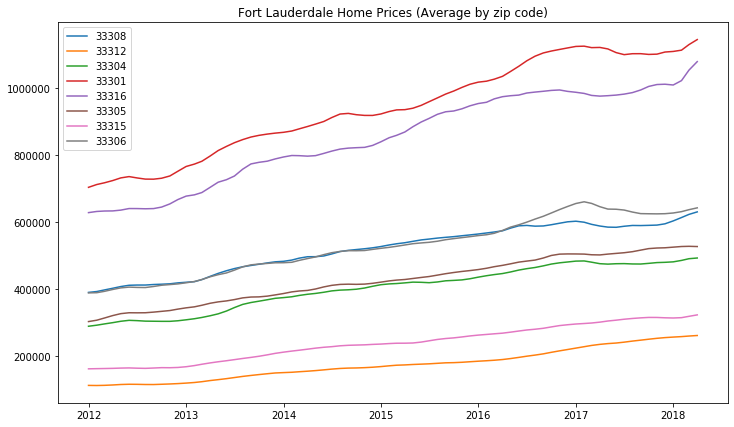

In [813]:
plt.figure(figsize=(12,7))
plt.plot(df1, label='33308')
plt.plot(df2, label='33312')
plt.plot(df3, label='33304')
plt.plot(df4, label='33301')
plt.plot(df5, label='33316')
plt.plot(df6, label='33305')
plt.plot(df7, label='33315')
plt.plot(df8, label='33306')
plt.title('Fort Lauderdale Home Prices (Average by zip code)')
plt.legend(loc='best');